In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

## 1. Realizar un análisis exploratorio de los datos para identificar relaciones entre variables, valores atípicos, tendencias, etc. 🔍

In [14]:
#importo el dataset
dataset = pd.read_csv("Mall_Customers.csv")
dataset.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [16]:
#Descripción
dataset.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Text(0.5, 1.0, 'Identificación de Datos Faltantes y Atípicos')

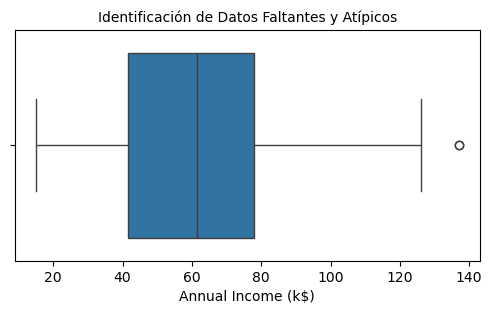

In [101]:
#identifico datos faltantes 

plt.figure(figsize=(6, 3))
sns.boxplot(x=dataset['Annual Income (k$)'])
plt.title('Identificación de Datos Faltantes y Atípicos', fontsize=10 )

## 2. Preprocesar los datos limpiándolos, tratando valores faltantes y transformándolos según sea necesario. ⚙️

In [18]:
# reviso datos faltantes
print("Cantidad de Registros con cero en Edad: ",dataset['Age'].isin([0]).sum())
print("Cantidad de Registros con cero en Ingresos Anuales: ",dataset['Annual Income (k$)'].isin([0]).sum())
print("Cantidad de Registros con cero en Puntuación de gastos: ",dataset['Spending Score (1-100)'].isin([0]).sum())

Cantidad de Registros con cero en Edad:  0
Cantidad de Registros con cero en Ingresos Anuales:  0
Cantidad de Registros con cero en Puntuación de gastos:  0


In [20]:
# Reemplazar todos los ceros con el valor medio
count_zeros = (dataset['Annual Income (k$)'] == 0).sum()

# Reemplazar los valores de 0 por la media
dataset['Annual Income (k$)']= dataset['Annual Income (k$)'].replace(0,dataset['Annual Income (k$)'].mean())

# Imprimir el número de valores modificados
print(f"Se cambiaron {count_zeros} valores.")

Se cambiaron 0 valores.


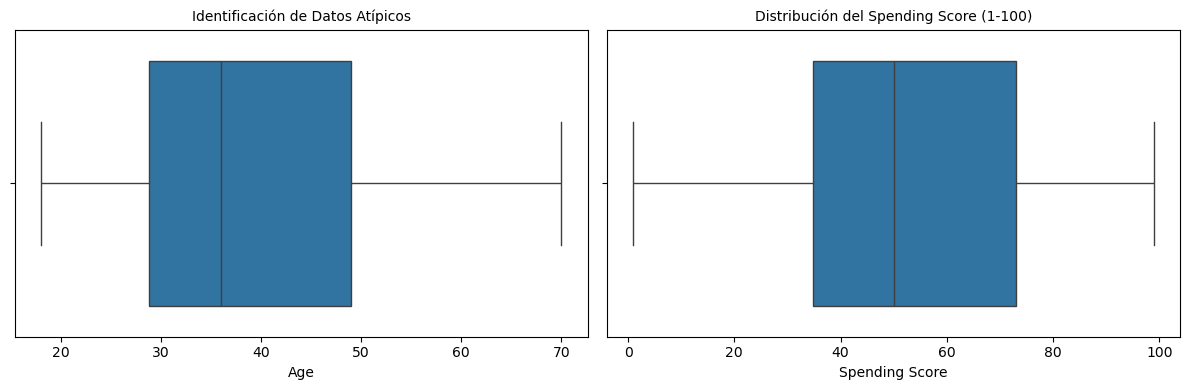

In [22]:
#Identifico los datos Atípicos Age

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  


sns.boxplot(x=dataset['Age'], ax=axes[0])
axes[0].set_title('Identificación de Datos Atípicos', fontsize=10)
axes[0].set_xlabel('Age')


sns.boxplot(x=dataset['Spending Score (1-100)'], ax=axes[1])
axes[1].set_title('Distribución del Spending Score (1-100)', fontsize=10)
axes[1].set_xlabel('Spending Score')


plt.tight_layout()
plt.show()



In [24]:
#Conteo de Datos Atípicos 

#Age
nivel_minimo=18
nivel_maximo=70
Total_Atipicos=((dataset['Age']<nivel_minimo)|
                (dataset['Age']>nivel_maximo)).sum()
print("El total de datos atípicos es {}".format(Total_Atipicos))

# Spending Score
nivel_minimo = 0
nivel_maximo = 100
Total_Atipicos_Spending = ((dataset['Spending Score (1-100)'] < nivel_minimo) | 
                           (dataset['Spending Score (1-100)'] > nivel_maximo)).sum()

print("El total de datos atípicos en Spending Score es {}".format(Total_Atipicos_Spending))


El total de datos atípicos es 0
El total de datos atípicos en Spending Score es 0


In [62]:
# reiviso los datos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## 3. Seleccionar las características más relevantes para entrenar el modelo utilizando selección de características. 📤📥

Características de interes para el agrupamiento:
- Age
- Annual Income (k$)	
- Spending Score (1-100)

In [26]:
# Filtro columnas del modelo 

print("Total de filas en el dataset:", dataset.shape[0])
dataset = dataset[["Age", "Annual Income (k$)","Spending Score (1-100)"]]
dataset.head(10)

Total de filas en el dataset: 200


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
5,22,17,76
6,35,18,6
7,23,18,94
8,64,19,3
9,30,19,72


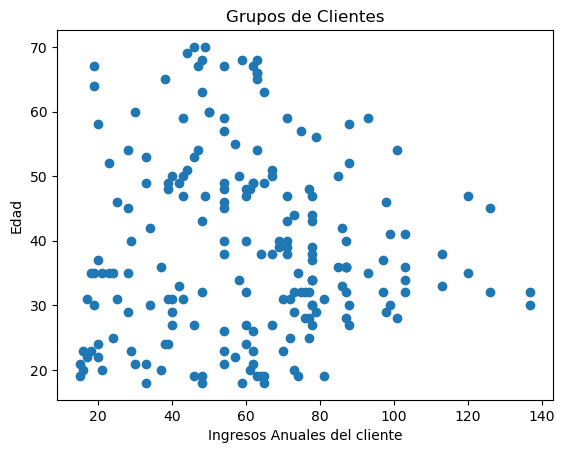

In [28]:
# Grafica antes del agrupamiento

plt.scatter(dataset['Annual Income (k$)'], dataset['Age'])
plt.xlabel('Ingresos Anuales del cliente')
plt.ylabel('Edad')
plt.title('Grupos de Clientes')
plt.show()

## 4. Entrenar el modelo configurando los diferentes hiperparámetros. 🪖

In [32]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])


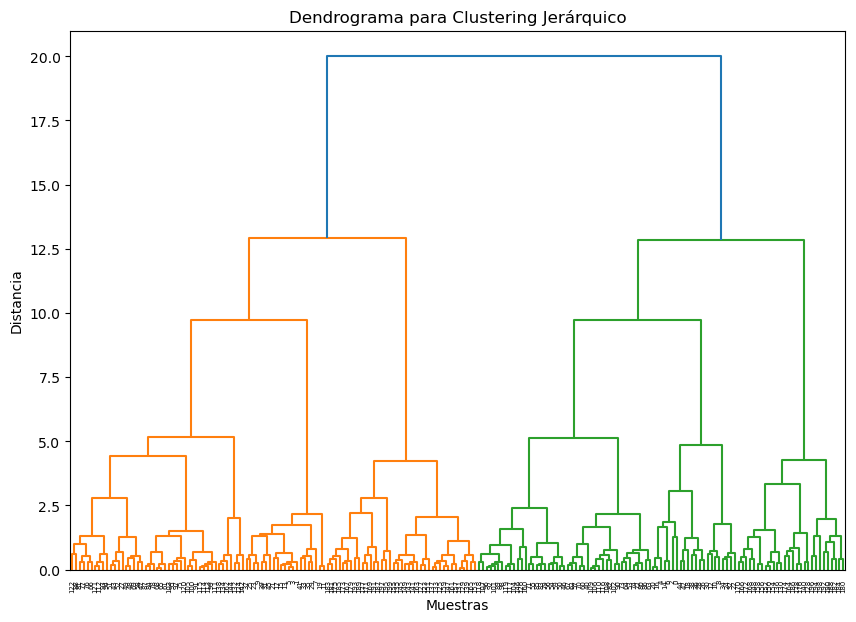

In [36]:
linked = linkage(scaled_data, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending')
plt.title("Dendrograma para Clustering Jerárquico")
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

In [63]:
#entrenamiento del modelo
Modelo = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = Modelo.fit_predict(scaled_data)

## 5. Evaluar el desempeño del modelo con métricas como Coeficiente de Silhouette, Índice de Calinski-Harabasz, etc 📈

In [65]:
# coeficiente de Silhouette
sil_score = silhouette_score(scaled_data, labels)
print(f'coeficiente de Silhouette: {sil_score}')

# Indice de calinski
ch_score = calinski_harabasz_score(scaled_data, labels)
print("Índice de Calinski-Harabasz:", ch_score)

#indice de Davies Bouldin
db_score = davies_bouldin_score(scaled_data, labels)
print("Índice de Davies Bouldin:", db_score)

coeficiente de Silhouette: 0.3614512741691407
Índice de Calinski-Harabasz: 102.01939926024943
Índice de Davies Bouldin: 1.0163821773024595


## 6. Realizar las diferentes gráficas que permitan visualizar los resultados del modelo 🖌️

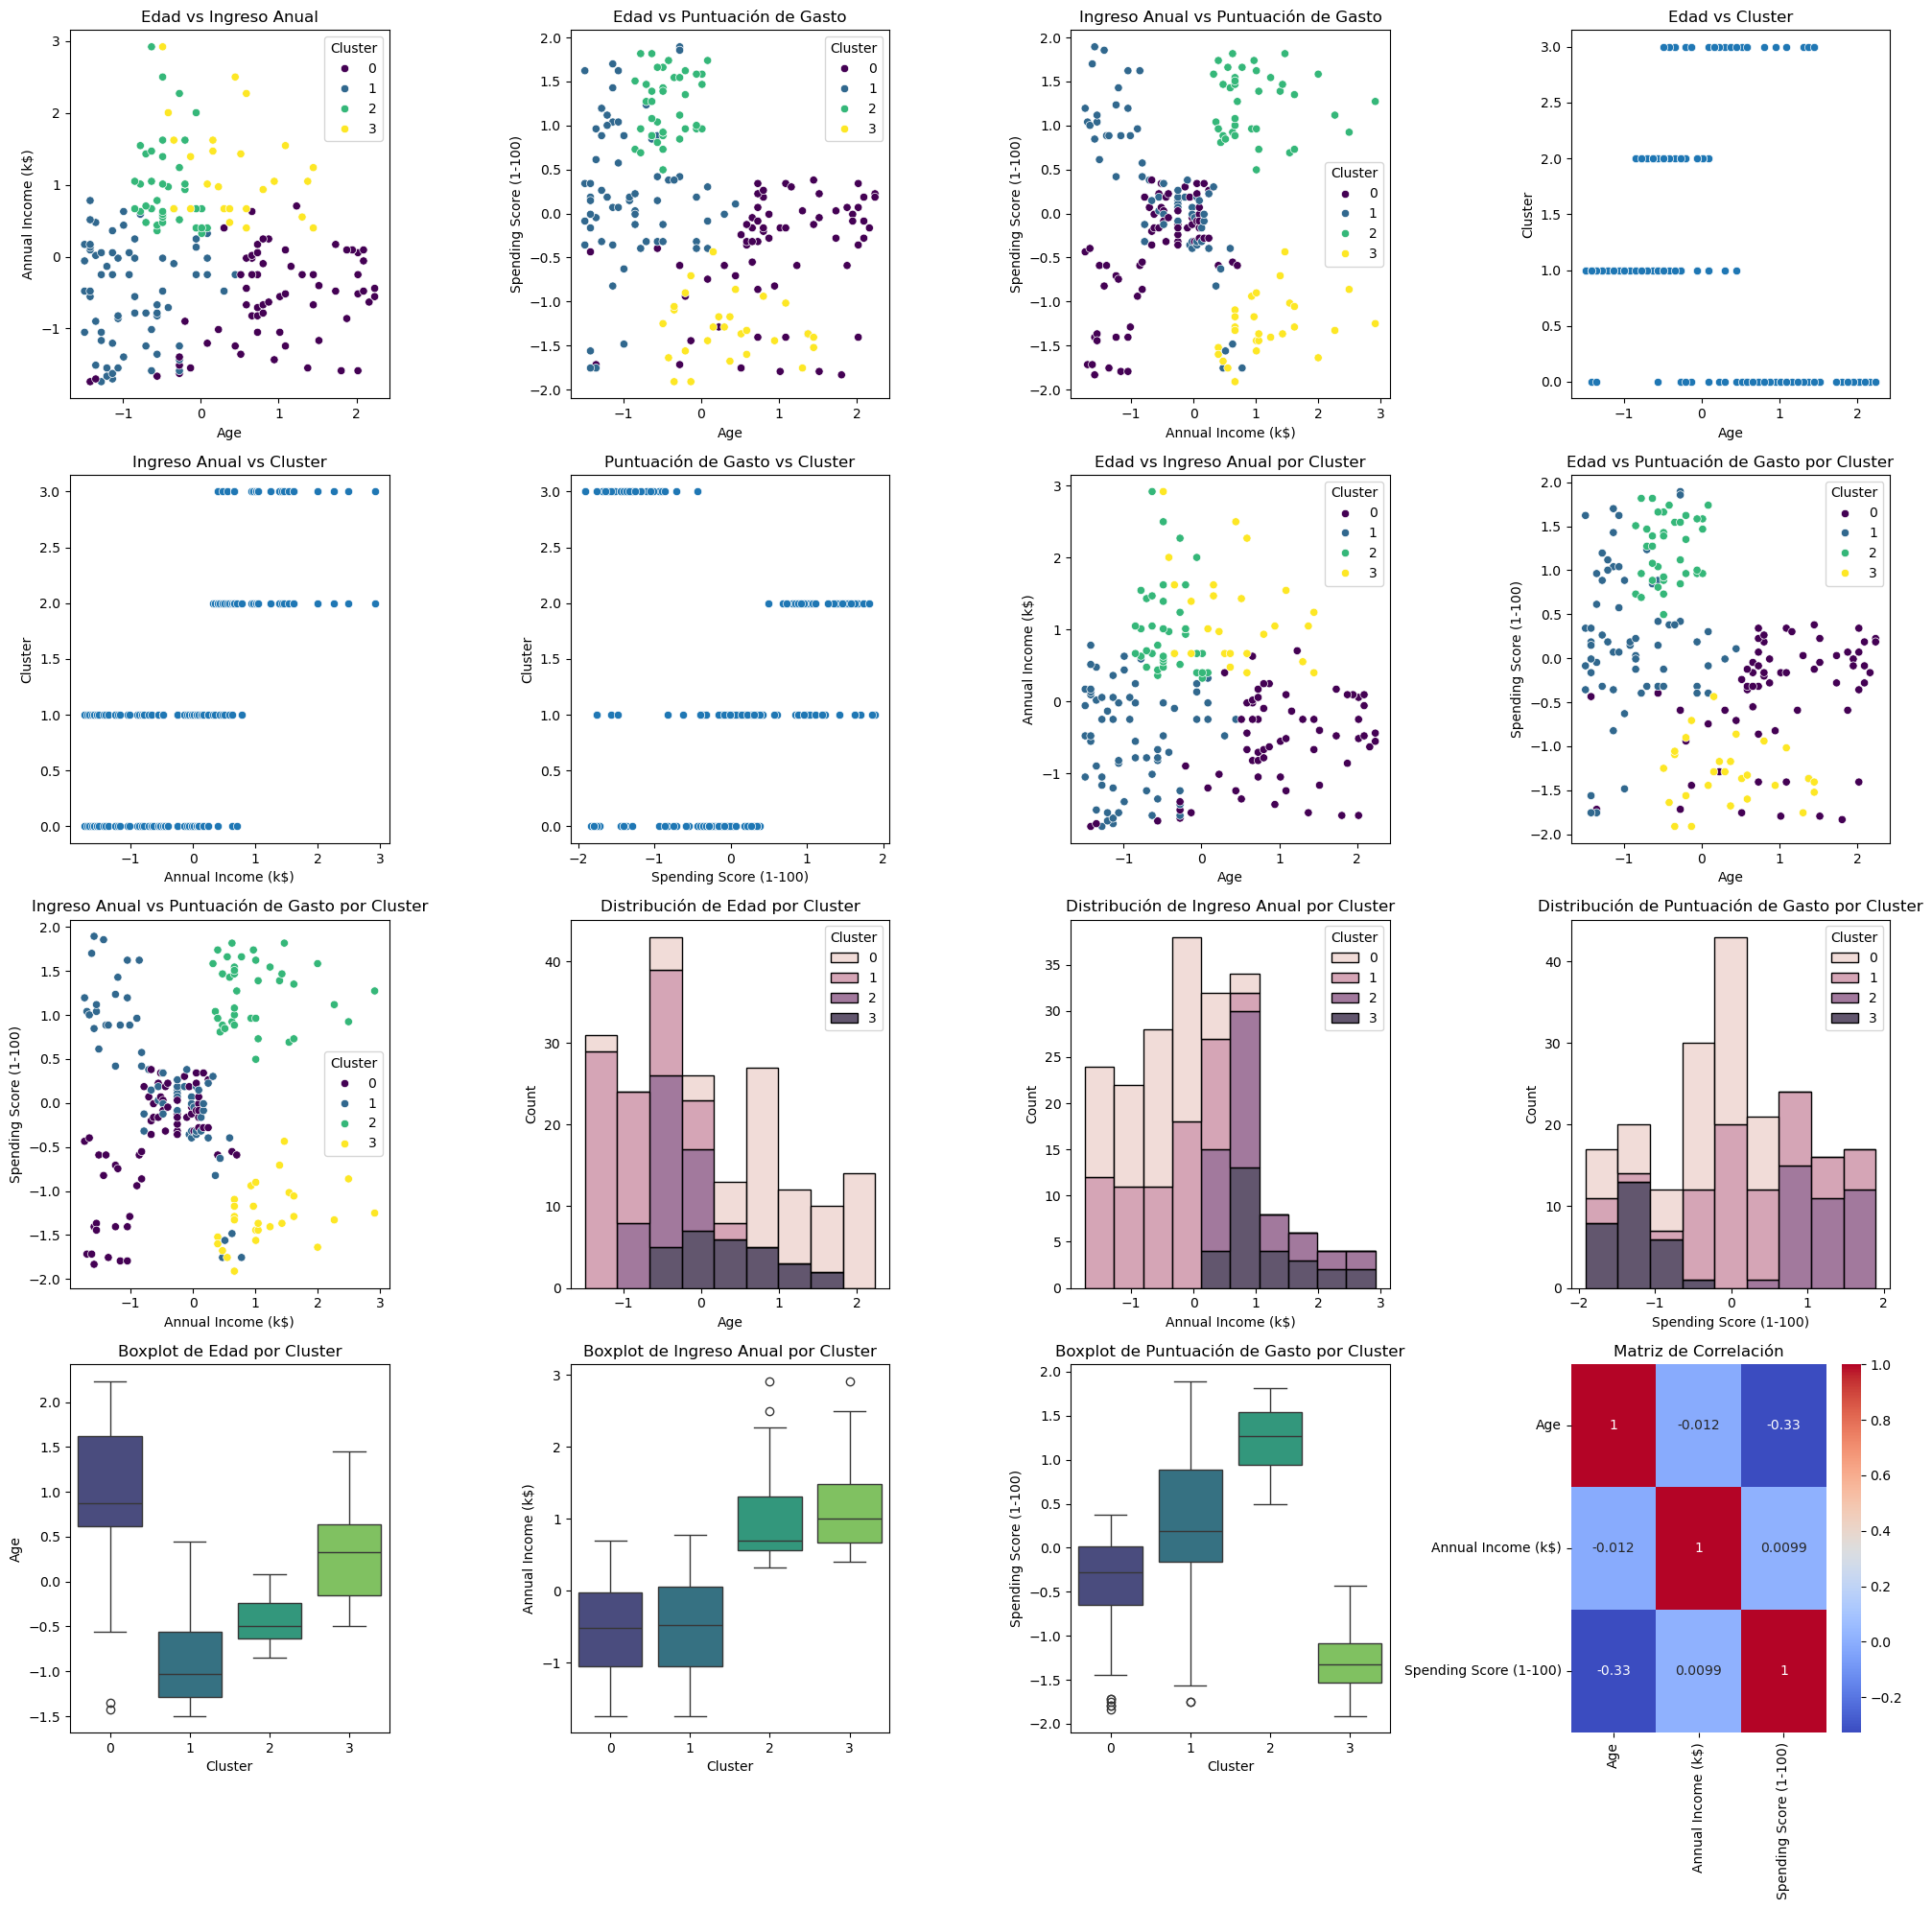

In [67]:

dataset['Cluster'] = Model.fit_predict(scaled_data)

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

sns.scatterplot(x=dataset['Age'], y=dataset['Annual Income (k$)'], hue=dataset['Cluster'], ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Edad vs Ingreso Anual')

sns.scatterplot(x=dataset['Age'], y=dataset['Spending Score (1-100)'], hue=dataset['Cluster'], ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Edad vs Puntuación de Gasto')

sns.scatterplot(x=dataset['Annual Income (k$)'], y=dataset['Spending Score (1-100)'], hue=dataset['Cluster'], ax=axes[0, 2], palette='viridis')
axes[0, 2].set_title('Ingreso Anual vs Puntuación de Gasto')

sns.scatterplot(x=dataset['Age'], y=dataset['Cluster'], ax=axes[0, 3], palette='viridis')
axes[0, 3].set_title('Edad vs Cluster')

sns.scatterplot(x=dataset['Annual Income (k$)'], y=dataset['Cluster'], ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Ingreso Anual vs Cluster')

sns.scatterplot(x=dataset['Spending Score (1-100)'], y=dataset['Cluster'], ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Puntuación de Gasto vs Cluster')

sns.scatterplot(x=dataset['Age'], y=dataset['Annual Income (k$)'], hue=dataset['Cluster'], ax=axes[1, 2], palette='viridis')
axes[1, 2].set_title('Edad vs Ingreso Anual por Cluster')

sns.scatterplot(x=dataset['Age'], y=dataset['Spending Score (1-100)'], hue=dataset['Cluster'], ax=axes[1, 3], palette='viridis')
axes[1, 3].set_title('Edad vs Puntuación de Gasto por Cluster')

sns.scatterplot(x=dataset['Annual Income (k$)'], y=dataset['Spending Score (1-100)'], hue=dataset['Cluster'], ax=axes[2, 0], palette='viridis')
axes[2, 0].set_title('Ingreso Anual vs Puntuación de Gasto por Cluster')

sns.histplot(data=dataset, x="Age", hue="Cluster", multiple="stack", ax=axes[2, 1])
axes[2, 1].set_title('Distribución de Edad por Cluster')

sns.histplot(data=dataset, x="Annual Income (k$)", hue="Cluster", multiple="stack", ax=axes[2, 2])
axes[2, 2].set_title('Distribución de Ingreso Anual por Cluster')

sns.histplot(data=dataset, x="Spending Score (1-100)", hue="Cluster", multiple="stack", ax=axes[2, 3])
axes[2, 3].set_title('Distribución de Puntuación de Gasto por Cluster')

sns.boxplot(x="Cluster", y="Age", data=dataset, ax=axes[3, 0], palette='viridis')
axes[3, 0].set_title('Boxplot de Edad por Cluster')

sns.boxplot(x="Cluster", y="Annual Income (k$)", data=dataset, ax=axes[3, 1], palette='viridis')
axes[3, 1].set_title('Boxplot de Ingreso Anual por Cluster')

sns.boxplot(x="Cluster", y="Spending Score (1-100)", data=dataset, ax=axes[3, 2], palette='viridis')
axes[3, 2].set_title('Boxplot de Puntuación de Gasto por Cluster')

sns.heatmap(dataset[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr(), annot=True, cmap='coolwarm', ax=axes[3, 3])
axes[3, 3].set_title('Matriz de Correlación')

plt.tight_layout()
plt.show()


## 7. Interpretar, analizar y documentar los resultados obtenidos.

Coeficiente de Silhouette: La puntuación de Silhouette obtenida es de aproximadamente 0.361, lo que sugiere una separación moderada entre los clústeres. Aunque este valor está por debajo de 1, que sería ideal, aún indica que los grupos están algo diferenciados. Sin embargo, existe cierto solapamiento o cercanía entre algunos de los clústeres, lo que podría indicar que el número de clusters puede no ser el óptimo o que algunas categorías podrían no estar suficientemente diferenciadas.

Índice de Calinski-Harabasz: El valor del Índice de Calinski-Harabasz es de 102.02, lo que sugiere que la estructura de los clústeres es razonablemente buena. Este índice evalúa la dispersión entre los clústeres en comparación con la dispersión interna dentro de los clústeres. Un valor más alto generalmente indica una mejor separación y una estructura más clara entre los grupos. En este caso, aunque no es extremadamente alto, nos muestra que la segmentación es aceptable.

Índice de Davies Bouldin: El Índice de Davies-Bouldin obtenido es de 1.016, lo que indica que la separación entre los clústeres es moderada. Un valor cercano a 0 sería ideal, ya que representaría clústeres perfectamente diferenciados. En este caso, el valor de 1.016 sugiere que hay una cierta cantidad de superposición entre los clústeres, lo que implica que la clasificación podría mejorarse, tal vez con una mayor diferenciación entre los grupos o ajustando el número de clústeres.